# Signature Map Inversion

In [12]:
# external packages
from esig.tosig import stream2logsig
import signatory as sg
import matplotlib.pyplot as plt
import numpy as np
import torch

# Buehler functionalities
from BuehlerVAE.src.utils.leadlag import leadlag
import BuehlerVAE.src.logsig_inversion as logsig_inversion

# own functionalities
from src.data.make_dataset import DataLoader
from src.features.data_transformer import Transformer

## Prepare Data

In [13]:
# Specify the data loader parameters
n = 5
n_points = 22 # change to 253 for yearly plot (n_points-1 returns)
nPeriods = 1/12 # change to 1 for yearly plot
gbm_params = {"S0": 1., "mu": 0.05, "sigma": 0.2, "T": nPeriods, "n_points": n_points, "n": n}

In [14]:
# Load different path types
seed = 42
gbm_loader = DataLoader(method="GBM", params=gbm_params, seed=seed)
paths, times = gbm_loader.create_dataset(output_type="np.ndarray")

# Plot lead-lag

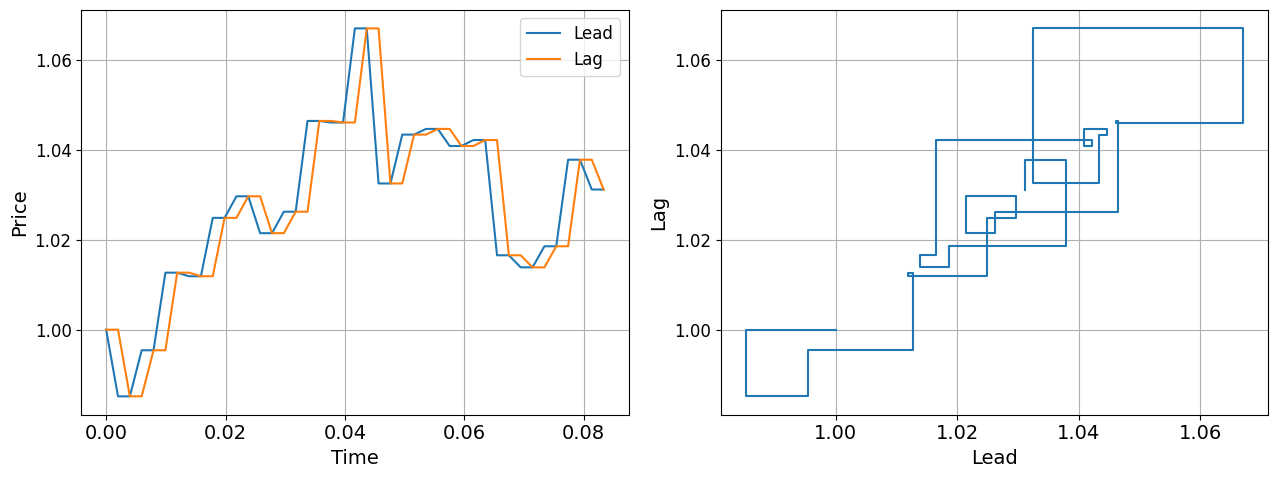

In [56]:
import src.visualization.set_plot_params 

fig, axs = plt.subplots(1, 2, figsize=(13,5))

lagged = leadlag(paths[:,3])
x_grid = np.linspace(0, nPeriods, len(lagged[:,0]))
axs[0].plot(x_grid, lagged[:,1], label = "Lead") # lead
axs[0].plot(x_grid, lagged[:,0], label = "Lag") # lag
axs[0].legend()
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Price")
axs[0].grid()

axs[1].plot(lagged[:,1], lagged[:,0])
axs[1].set_xlabel("Lead")
axs[1].set_ylabel("Lag")
axs[1].grid()

plt.tight_layout()
plt.show()

## Insertion Method (Signatory)

### Time augmented method

In [15]:
# convert paths to torch tensor for signatory library
paths_torch = Transformer().arrays_to_torch_tensor(times, paths)
# set the depth of the signature (or order) 
# if granularity equals depth, output will be of same format as input (depth = int(nPeriods/dt))
depth = 21
signatures_augm = sg.signature(paths_torch, depth)
inverted_paths_augm = sg.invert_signature(signatures_augm, depth=depth, channels=2, initial_position=paths_torch[:, 0, :])
times_recovered_augm, paths_recovered_augm = Transformer().torch_tensor_to_arrays(inverted_paths_augm)

### lead-lag method

In [16]:
# convert paths to torch tensor for signatory library
for i in range(paths.shape[1]):
    leadlag_path = torch.from_numpy(leadlag(paths[:,i]))
    if i == 0:
        paths_torch_leadlag = leadlag_path.unsqueeze(0)
    else:
        paths_torch_leadlag = torch.cat((paths_torch_leadlag, leadlag_path.unsqueeze(0)), 0)
        
signatures = sg.signature(paths_torch_leadlag, depth)
inverted_paths_leadlag = sg.invert_signature(signatures, depth=depth, channels=2, initial_position=paths_torch_leadlag[:, 0, :])
leadlag_recovered = inverted_paths_leadlag.numpy()

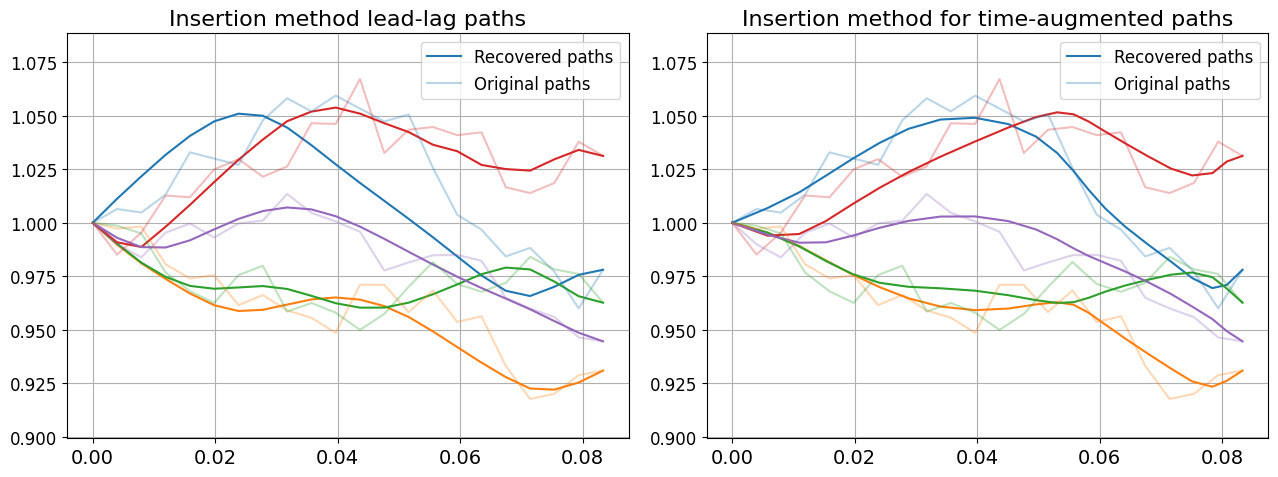

In [17]:
import src.visualization.set_plot_params 
# Determine the y-limits based on the data across both subplots
y_min = min(np.min(leadlag_recovered[:,:,1]), np.min(paths), np.min(paths_recovered_augm))*0.98
y_max = max(np.max(leadlag_recovered[:,:,1]), np.max(paths), np.max(paths_recovered_augm))*1.02

fig, axs = plt.subplots(1, 2, figsize=(13,5))

# lead-lag paths
for i in range(leadlag_recovered.shape[0]):
    axs[0].plot(np.linspace(0, nPeriods, depth+1), leadlag_recovered[i,:,1], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
axs[0].set_prop_cycle(None)
# Plot original paths with lower alpha 
for i in range(paths.shape[1]):
    axs[0].plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
# Set unified y-limits
axs[0].set_ylim(y_min, y_max)
axs[0].set_title("Insertion method lead-lag paths")
axs[0].legend()
axs[0].grid()

# time-augmented paths
for i in range(paths_recovered_augm.shape[1]):
    axs[1].plot(times_recovered_augm, paths_recovered_augm[:,i], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
axs[1].set_prop_cycle(None)
# Plot original paths with lower alpha 
for i in range(paths.shape[1]):
    axs[1].plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
axs[1].set_ylim(y_min, y_max)
axs[1].set_title("Insertion method for time-augmented paths")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## Buehler log-signature Inversion

### lead-lag log-signature method

In [18]:
pip = 0.001
n_pips = 5 * 10

n_iterations = 100
n_organisms = 400

logsig_order = 4
paths_recovered_buehler = []
for i in range(paths.shape[1]):
    current_path = paths[:,i]
    logsig = stream2logsig(leadlag(current_path), logsig_order)
    recovered_path, loss = logsig_inversion.train(
        logsig, logsig_order, n_iterations, n_organisms, n_points, pip, n_pips
    )
    
    paths_recovered_buehler.append(recovered_path+1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

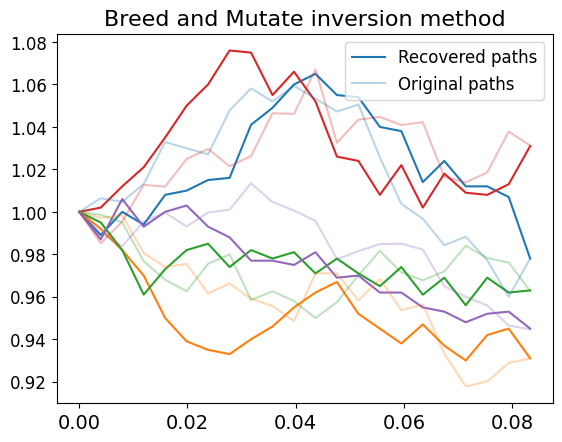

In [19]:
plt.figsize=(6.5, 5)
# Plot paths
for i in range(len(paths_recovered_buehler)):
    plt.plot(np.linspace(0, nPeriods, n_points), paths_recovered_buehler[i], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
plt.gca().set_prop_cycle(None)
# Plot original paths with lower alpha
for i in range(paths.shape[1]):
    plt.plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
plt.title("Breed and Mutate inversion method")
plt.legend()
plt.show()

### Time augmented method

Note that the the `train` method of Buehler uses leadlag in its function. It would not be methodologically sound if we use the time augmented method here and thus we disregard it.